# Setup

## Import libraries

In [1]:
import os
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from ipywidgets import interact, widgets, fixed
from plotly.express import imshow as imshow_interactive

In [2]:
from dotenv import load_dotenv

BASE_DIR = pathlib.Path(__name__).resolve().parent.parent.parent.parent
load_dotenv(BASE_DIR / '.env')
DATA_PATH = pathlib.Path(os.getenv("DATA_PATH"))

## Import core modules

In [3]:
import sys
import pathlib
SRC_DIR = str(pathlib.Path(__name__).resolve().parent.parent.parent)
sys.path.append(SRC_DIR)

In [4]:
from scanplot.setup_logger import logger

In [5]:
from scanplot.utils.read_image import read_image_rgb, read_image_gray
from scanplot.utils.drawing import draw_image, draw_points_on_canvas, draw_points_on_image, \
    draw_bbox
from scanplot.utils.widgets import init_points_num_slider, init_points_density_slider

In [6]:
from scanplot.core.template_match import template_match, detect_points, \
    find_tolerance_limit

from scanplot.core.clustering import simplify_points, agglomerative_clustering, meanshift_clustering

from scanplot.core.preprocess import replace_black_pixels

from scanplot.core.conv_map_operations import invert_convolution_map, normalize_map, \
    get_first_N_maximums, remove_nan_inf


from scanplot.core.process_template import template_tresholding, extract_largest_component, find_bbox, \
    crop_image, frame_image, is_grayscale, reconstruct_template_mask

from scanplot.core.hough_transform import generalized_hough_transform

from scanplot.core.parameters_search import linear_parameter_transform, get_corr_map_maximums

from scanplot.core.nms import apply_nms, point_to_bbox, get_bbox_from_point, get_bbox_center

In [7]:
# convolution implementation
from scanplot.core.convolution_from_stratch import get_image_part, sqdiff, \
    compute_mask_pixel_ratio, compute_mask_pixel_ratio_v2, sqdiff_normed_modification, \
    sqdiff_normed, cv_sqdiff_normed

In [8]:
from scanplot.core.reconstruction import get_bbox_by_center_point, \
    insert_template_into_image, add_template_layer, add_template_layer_light

from scanplot.core.process_template import get_binary_mask

# Pipeline

## Upload plot and template

In [9]:
PLOT_NUMBER = 3
MARKER_NUMBER = 1

PLOT_PATH = DATA_PATH / f"plot{PLOT_NUMBER}.png"
TEMPLATE_PATH = DATA_PATH / "markers_same_shape" / f"plot{PLOT_NUMBER}_marker{MARKER_NUMBER}.png"

In [10]:
source_image = read_image_rgb(PLOT_PATH)
source_template = read_image_rgb(TEMPLATE_PATH)

image = replace_black_pixels(source_image)
template = replace_black_pixels(source_template)

DEBUG - preprocess.py - replace_black_pixels: Number of black pixels on image: 1414
DEBUG - preprocess.py - replace_black_pixels: Number of black pixels on image: 0


In [11]:
h_image, w_image = image.shape[0], image.shape[1]
h_template, w_template = template.shape[0], template.shape[1]

h_image, w_image

(400, 500)

([], [])

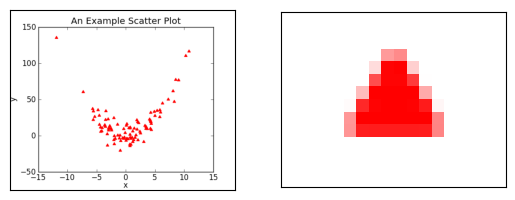

In [12]:
plt.subplot(1, 2, 1)
draw_image(image)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(template)
plt.xticks([]); plt.yticks([])

## Add ROI (optional)

In [13]:
# imshow_interactive(image)

In [14]:
# x_min, x_max, y_min, y_max = 221, 458, 47, 418
# roi_bbox = (x_min, x_max, y_min, y_max)

# image = crop_image(image, roi_bbox)

In [15]:
# imshow_interactive(image)

## Tresholding

([], [])

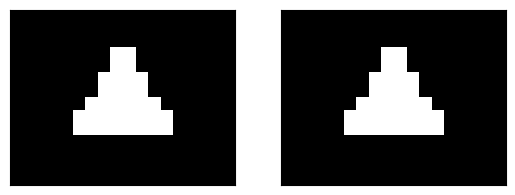

In [16]:
TRESHOLD_VALUE = 190
template_mask = template_tresholding(template, TRESHOLD_VALUE)
new_template_mask = reconstruct_template_mask(template_mask)

image_mask = template_tresholding(image, TRESHOLD_VALUE)

fig = plt.figure()
plt.subplot(1, 2, 1)
draw_image(template_mask)
plt.xticks([]); plt.yticks([])

plt.subplot(1, 2, 2)
draw_image(new_template_mask)
plt.xticks([]); plt.yticks([])

In [18]:
image_mask_binary = get_binary_mask(image_mask)
image_mask_binary_inverted = 1 - image_mask_binary
# imshow_interactive(image_mask_binary_inverted)

## Template matching

In [19]:
# method_name = 'SQDIFF_MODIFICATION_V3_WITH_HOUGH'
method_name = 'SQDIFF_MODIFICATION_V2'
method = "cv.TM_SQDIFF_NORMED"

convolution_map, _ = template_match(image, template, template_mask, method)
convolution_map2, _ = template_match(image, template, new_template_mask, method)

DEBUG - template_match.py - template_match: Convolution map bounds: (0.0, 1.1413422)
DEBUG - template_match.py - template_match: Convolution map was inverted
DEBUG - template_match.py - template_match: Convolution map bounds: (0.0, 1.1413422)
DEBUG - template_match.py - template_match: Convolution map was inverted


## Hough transform

In [20]:
accumulator = generalized_hough_transform(image, template, norm_result=True, crop_result=True)

assert convolution_map.shape == accumulator.shape

## Combine convolution maps

In [21]:
convolution_map = normalize_map(convolution_map)
convolution_map2 = normalize_map(convolution_map2)

convolution_map3 = convolution_map + 0.7 * convolution_map2
convolution_map3 = normalize_map(convolution_map3)

convolution_map4 = convolution_map + 0.6 * accumulator
convolution_map4 = normalize_map(convolution_map4)

In [22]:
# imshow_interactive(convolution_map)

## Interactive parameters search

1) `points_num` - отвечает за количество точек (чем больше, тем больше точек детектируется)

`points_num` = 0 => 1 точка

`points_num` = 100 => бесконечно много точек 


2) `points_density` - отвечает за плотность точек (чем больше, тем **разреженнее** результат)

`points_density` = 0 => не применяем NMS

`points_density` = 100 => убираем очень много соседей

In [23]:
# TODO: move to separate module

def detect_points_on_map(
        points_num: float,
        points_density: float,
        correlation_map: np.ndarray,
        draw_detections: bool = True,
        return_result: bool = False,
        figure_size: int = 10,
        marker_size: int = 60,
        marker_color: str = "yellow"
) -> np.ndarray | None:
    
    ## transform parameters
    corr_map_treshold = linear_parameter_transform(points_num, a=-0.01, b=1)
    iou_treshold = linear_parameter_transform(points_density, a=-0.01, b=1)

    ## get max points
    max_points, _ = get_corr_map_maximums(
        correlation_map=correlation_map,
        treshold=corr_map_treshold
    )
    
    ## NMS
    actual_points = apply_nms(
        points=max_points,
        correlation_map=correlation_map,
        iou_treshold=iou_treshold,
        bbox_width=w_template,   # TODO: this is global variable, fix it (!)
        bbox_height=h_template   # TODO: this is global variable, fix it (!)
    )
    x_nms = actual_points[:, 0]
    y_nms = actual_points[:, 1]
    number_of_points = len(actual_points)


    ## draw founded points on original image
    if draw_detections:
        plt.figure(figsize=(figure_size, figure_size))
        draw_image(source_image)
        plt.scatter(x_nms, y_nms, 
                    s=marker_size, c=marker_color, marker="*", 
                    edgecolors='black', linewidths=0.2)
        plt.xticks([]); plt.yticks([])
        plt.title(f"{corr_map_treshold=:.3f}, {iou_treshold=:.2f}, {number_of_points=}")
        plt.show()

    if return_result:
        return actual_points

In [ ]:
# parameters for drawing detections (may be customized)
figure_size = 12
marker_size = 200
marker_color = "yellow"


interact(
    detect_points_on_map,
    points_num=init_points_num_slider(),  # variable
    points_density=init_points_density_slider(),  # variable
    correlation_map=fixed(convolution_map4),  # constants
    draw_detections=fixed(True),
    return_result=fixed(False),
    figure_size=fixed(figure_size),
    marker_size=fixed(marker_size),
    marker_color=fixed(marker_color),
    continuous_update=True
);

In [27]:
points = detect_points_on_map(points_num=47,
    points_density=20,
    correlation_map=convolution_map4,
    draw_detections=False,
    return_result=True)

points = points.astype(np.int64)

## Experiments

In [29]:
reconstruction = np.zeros_like(image) + 255
layers = np.zeros_like(image[:, :, 0], dtype=np.int64)

template_binary = get_binary_mask(template_mask)
template_binary = template_binary.astype(np.int64)

ALPHA = 0.0001

history = []

for point in points:
    bbox = get_bbox_by_center_point(center_point=point, width=w_template, height=h_template)
    reconstruction = insert_template_into_image(
        reconstruction,
        template,
        bbox,
        template_mask
    )

    layers = add_template_layer(layers, bbox, template_binary)


    diff = cv.matchTemplate(image, reconstruction, cv.TM_CCOEFF_NORMED)[0][0]
    # diff = sqdiff_normed(image, reconstruction)
    # diff = sqdiff_normed(image, reconstruction)

    layers_count = len(np.where(layers > 1)[0])

    history.append(diff - ALPHA * layers_count)

    # plt.imshow(reconstruction)
    # plt.title(f"{diff=}")
    # plt.show()

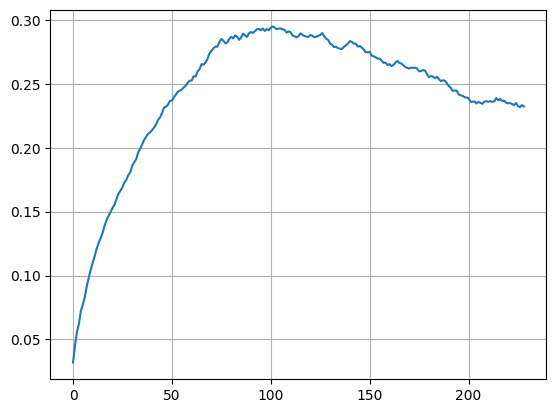

In [30]:
plt.plot(history)
plt.grid()

## Optimization

In [31]:
from scanplot.core.convolution_from_stratch import sqdiff_normed, sqdiff

In [32]:
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)

In [42]:
ALPHA = 1e-4
# BETA = 1e-4


def loss(
        x,
        convolution_map, image,
        template, template_mask,
        w_template, h_template,
        template_binary=None
):
    n = len(x)
    loss_result = np.zeros(n)
    for i in range(n):
        particle = x[i]

        points = detect_points_on_map(
            points_num=particle[0],
            points_density=particle[1],
            correlation_map=convolution_map,
            draw_detections=False,
            return_result=True
        )
        points = points.astype(np.int64)
        reconstruction = np.zeros_like(image) + 255
        layers = np.zeros_like(image[:, :, 0], dtype=np.int64)
        # layers_light = np.zeros_like(image[:, :, 0], dtype=np.int64)
        
        for point in points:
            bbox = get_bbox_by_center_point(center_point=point, width=w_template, height=h_template)
            insert_template_into_image(
                reconstruction,
                template,
                bbox,
                template_mask
            )
            add_template_layer(layers, bbox, template_binary)
            # add_template_layer_light(layers_light, bbox, template_binary)


        layers_count = len(np.where(layers > 1)[0])
        # background_overlap = np.sum(layers_light * image_mask_binary_inverted)

        diff = cv.matchTemplate(image, reconstruction, cv.TM_CCOEFF_NORMED)[0][0]
        # diff = np.linalg.norm(image - reconstruction)
        # diff = sqdiff_normed(image, reconstruction, template_mask=None)
        # diff = sqdiff(image, reconstruction)
        # loss_result[i] = - diff
        loss_result[i] = ALPHA * layers_count - diff
        # loss_result[i] = BETA * background_overlap + ALPHA * layers_count - diff

    return loss_result

In [43]:
min_points_num = 1
min_points_density = 5
max_points_num = 70
max_points_density = 80

x_min = [min_points_num, min_points_density]
x_max = [max_points_num, max_points_density]
bounds = (x_min, x_max)

options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = GlobalBestPSO(n_particles=10, dimensions=2, options=options, bounds=bounds)

In [44]:
template_binary = get_binary_mask(template_mask)
template_binary = template_binary.astype(np.int64)

cost, pos = optimizer.optimize(
    loss, iters=40, verbose=True,
    convolution_map=convolution_map4,
    image=image,
    template=template,
    template_mask=template_mask,
    w_template=w_template,
    h_template=h_template,
    template_binary=template_binary
)

2024-11-14 20:41:55,687 - pyswarms.single.global_best - INFO - Optimize for 40 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|40/40, best_cost=-.326
2024-11-14 20:41:59,181 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.32619936084747314, best pos: [67.6471375  52.08215826]


In [45]:
best_points_num, best_points_density = pos.astype(np.int64)
best_points_num, best_points_density

(67, 52)

In [ ]:
# parameters for drawing detections (may be customized)
figure_size = 12
marker_size = 120
marker_color = "yellow"

interact(
    detect_points_on_map,
    points_num=init_points_num_slider(start_value=best_points_num),
    points_density=init_points_density_slider(start_value=best_points_density),
    correlation_map=fixed(convolution_map4),
    draw_detections=fixed(True),
    return_result=fixed(False),
    figure_size=fixed(figure_size),
    marker_size=fixed(marker_size),
    marker_color=fixed(marker_color),
    continuous_update=True
);

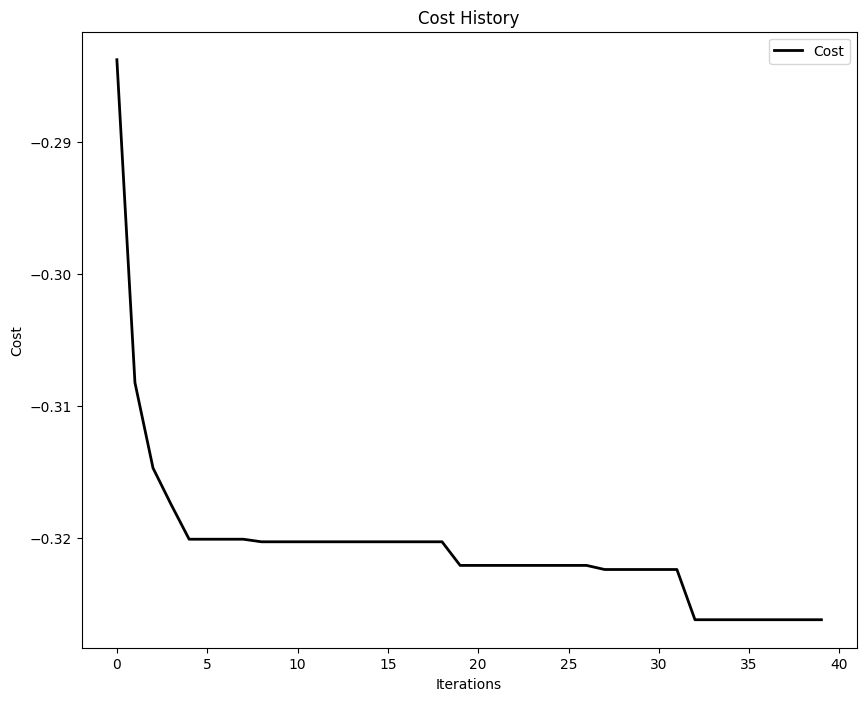

In [47]:
plot_cost_history(cost_history=optimizer.cost_history)
plt.show()